## Handling Outliers and Transforming Attributes

This notebook contains examples and code from various sources:

<a href="https://www.kaggle.com/getting-started/52652">Kaggle Data Cleaning Challenge </a>
<br><a href="https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/"> Outlier Detection PYOD Module Tutorial</a>

The goal of this notebook is to illustrate how noise and outliers can be detected and handled, and how to perform different transformations on the data.

Detailed explanations for important code snippets are provided by Mervat Abuelkheir as part of the CSEN1095 Data Engineering Course.

Pay attention to the <span style="color:red"> <b> paragraphs in bold red</b></span>; they ask you to do something and provide input!


## Part 1 - Scale, Standardize, and Normalize

Scaling, standardization, and normalization all involve the transformation of the values of numeric variables so that the transformed data points have specific helpful properties. 

<b>Scaling</b> involves changing the range of your data, so that it fits within a specific scale, like 0-100 or 0-1. Some ML algorithms, such as support vector machines (SVM), k-nearest neighbors (KNN), or k-means, are based on measures of how far apart data points are (i.e. distances between data points), so a change of "1" in any numeric feature is given the same importance. Therefore, variables/attributes with larger value ranges will outweigh variables with smaller ranges and will distort the distance computations for these methods.

For example, you might be looking at the prices of some products in both EGP and US Dollars. One US Dollar is worth about 17 EGP, but if you don't scale your prices, methods like SVM or KNN will consider a difference in price of 1 EGP as important as a difference of 1 US Dollar! With currency, you can convert between currencies. But what about if you're looking at something like height and weight? Or age and salary? It's not entirely clear how many pounds should equal one inch (or much money equals one year of age). By scaling your variables, you can help compare different variables on equal footing.

<b>Standardization</b>, or z-score normalization, involves changing the range of your data based on the mean and standard deviation. The attribute will have a mean of zero and variance of 1. 

<b>Normalization</b> involves changing the shape of the distribution of your data. You change your observations so that they can be described as a normal distribution. Normalize your data if you're going to use an ML technique that assumes your data is normally distributed, such as linear regression, linear discriminant analysis (LDA), or Gaussian naive Bayes. 


### Important Notes (taken from Kaggle)

Scaling your data is a very crucial procedure in most ML algorithms.

    Scaling is used to make all features contribute the same amount in prediction. Refer to the weight and height, salary and age examples above.
    Scaling makes the algorithms converge faster since it transform the variable space in to a much smaller range.

When it is time to work on training and test datasets, you must apply scaling separately on train and test sets in order to correctly represent the distribution of the variables in each set. 

### The Kickstarter Campaign Dataset

Let's experiment with these preprocessing tasks on a dataset. The dataset we will use is the <a href="https://data.world/rdowns26/kickstarter-campaigns"><b>Kickstarter Campaign dataset</b></a>. Kickstarter is an online crowdfunding platform aimed at helping people get their ideas funded while building a community of fans to support their ideas. While Kickstarter publishes many advice and best-practices articles on their blog, over half of campaigns still fail.

This dataset contains data on 20,632 Kickstarter campaigns on the site as of February 1st 2017. Download the dataset from <a href="https://www.kaggle.com/kemical/kickstarter-projects#ks-projects-201801.csv">this link on Kaggle</a>. Important attributes are described below:

<b>project</b>: a finite work with a clear goal that you’d like to bring to life (aka campaign)
<br><b>funding goal</b>: amount of money that a creator needs to complete their project
<br><b>name</b>: name of project on Kickstarter
<br><b>blurb</b>: the short description displayed under the name of your project and on the browse page
<br><b>pledged</b>: amount of money that a project has raised
<br><b>backers</b>: number of people that have supported the project at the point of the API pull
<br><b>state</b>: successful, failed, cancelled, live or suspended
<br><b>deadline</b>: deadline given for successful funding
<br><b>state changed</b>: state changed when campaign went to success or failure
<br><b>created at</b>: time the project was created at
<br><b>launched at</b>: time the project was launched at
<br><b>usd_pledged</b>: conversion in US dollars of the pledged column (conversion done by kickstarter).
<br><b>usd_pledge_real</b>: conversion in US dollars of the pledged column (conversion from Fixer.io API).
<br><b>usd_goal_real</b>: conversion in US dollars of the goal column (conversion from Fixer.io API).
<br>Other attributes in this dataset: <b>country</b>, <b>currency</b>, <b>category</b>


Let's begin by some routine imports and data loading:

In [7]:
# Modules we'll use
import pandas as pd
import numpy as np

# For min_max scaling
from sklearn.preprocessing import MinMaxScaler

# For z-score scaling
from sklearn.preprocessing import StandardScaler

# For Box-Cox Normalization
from scipy import stats

# Plotting modules
from pandas.plotting import scatter_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Read in all our data
kickstarters_2017 = pd.read_csv("https://www.kaggle.com/kemical/kickstarter-projects#ks-projects-201801.csv")

# Set seed for reproducibility
np.random.seed(0)

# Inspect the first couple of rows
kickstarters_2017.head()

ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency    deadline     goal  \
0          Poetry    Publishing      GBP  2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD  2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD  2013-02-26  45000.0   
3           Music         Music      USD  2012-04-16   5000.0   
4    Film & Video  Film & Video      USD  2015-08-29  19500.0   

              launched  pledged     state  backers country  usd pledged  \
0  2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1  2017-09-02 04:43:57   2421.0    failed       15      US        100.0   
2  2013-01-12 00:20:50    220.0    failed        3      US        220.0   
3  2012-03-17 03:24:11      1.0    failed        1      US          1.0   
4  2015-07-04 08:35:03   1283.0  canceled       14      US       1283.0   

   usd_pledged_real  usd_goal_real  
0               0.0        1533.95  
1            2421.0       30000.00  
2             220.0       45000.00  
3               1.0        5000.00  
4            1283.0       19500.00

#### Scaling one attribute

Now we proceed to scale one attribute, the <b>goal</b> attribute. We will use the `MinMaxScaler()` method to perform min-max scaling. We will illustrate the difference in scale by distribution plots.

Text(0.5, 1.0, 'Scaled data')

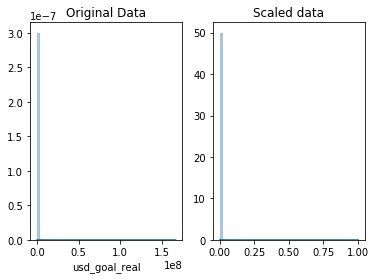

In [3]:
# Select the usd_goal_real column
usd_goal_original = kickstarters_2017.usd_goal_real 

# Scale the goals from 0 to 1 using MinMaxScaler()
# fit computes the minimum and maximum to be used for later scaling, and transform performs the scaling
usd_goal_scaled = MinMaxScaler().fit_transform(kickstarters_2017[["usd_goal_real"]]) 
# MinMaxScaler does not accept Series and needs a DataFrame object. 
# A DataFrame is a 2-d array, with potential multiple columns
# In this case, we have to use kickstarters_2017[["goal"]] and NOT kickstarters_2017["goal"] or kickstarters_2017.goal
# Because kickstarters_2017["goal"] results in a Series - a 1-d array that is practically one row with all the values
# while kickstarters_2017[["goal"]] results in a DataFrame - a 2-d array with multiple row and one column, which is what MinMaxScaler() needs

# Plot the original & scaled data together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(usd_goal_original, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(usd_goal_scaled, ax=ax[1])
ax[1].set_title("Scaled data")

Let's try a different scaling method; the `StandardScaler()`. This is the z-score scaling, which will scale the attribute values with zero mean and unit standard deviation.

Text(0.5, 1.0, 'Scaled data - z-score')

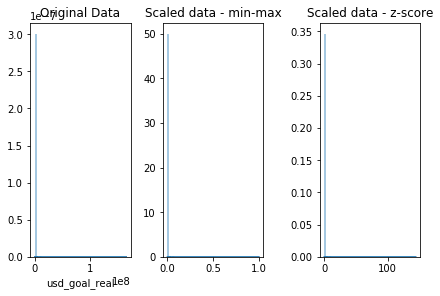

In [4]:
# Scale the usd_goals_real using mean and SD
usd_goal_z_scaled = StandardScaler().fit_transform(kickstarters_2017[["usd_goal_real"]]) 

# Plot the original & scaled data with both methods to compare
fig, ax=plt.subplots(1,3, constrained_layout=True) # layout spaces out the figures for more visibility
sns.distplot(usd_goal_original, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(usd_goal_scaled, ax=ax[1])
ax[1].set_title("Scaled data - min-max")
sns.distplot(usd_goal_z_scaled, ax=ax[2])
ax[2].set_title("Scaled data - z-score")

<b><span style="color:red">Try the same code on the goal attribute. What's your observation?</span></b>

#### Scaling two attributes at once

Let's scale the <b>usd_goal_real</b> and the <b>usd_pleadged_real</b> attributes in one take. We can do that because the MinMaxScaler can handle multiple DataFrame columns at once.

Text(0.5, 1.0, 'z-score Scaled Attributes')

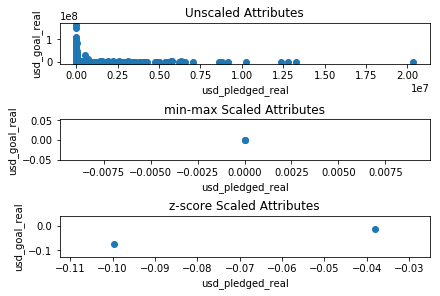

In [23]:
usd_original = kickstarters_2017[['usd_pledged_real','usd_goal_real']] # Select only two attributes from the dataset 

# Scale
usd_minmax_scaled = MinMaxScaler().fit_transform(usd_original) 
usd_z_scaled = StandardScaler().fit_transform(usd_original) 

# Since we are working with two attributes, we can use a scatter plot to visualize the effect of scaling
fig, ax=plt.subplots(3,1, constrained_layout=True)
ax[0].scatter(usd_original['usd_pledged_real'],usd_original['usd_goal_real'])
ax[0].set(xlabel='usd_pledged_real', ylabel='usd_goal_real')
ax[0].set_title("Unscaled Attributes")
ax[1].scatter(usd_minmax_scaled[0],usd_minmax_scaled[1])
ax[1].set(xlabel='usd_pledged_real', ylabel='usd_goal_real')
ax[1].set_title("min-max Scaled Attributes")
ax[2].scatter(usd_z_scaled[0],usd_z_scaled[1])
ax[2].set(xlabel='usd_pledged_real', ylabel='usd_goal_real')
ax[2].set_title("z-score Scaled Attributes")

#### Normalization

Now let's try normalizing the <b>pledged</b> attribute using the Box-Cox normalization method.

The Box-Cox normalization transforms a non-normal attribute into an attribute with normal distribution. The Box-Cox transformation is a formula that has an exponent, lambda `λ`, which varies from -5 to 5. All values of `λ` are considered by the transformation function and the optimal value for your data is selected. The “optimal value” is the one which results in the best approximation of a normal distribution curve. 

This transformation only works when the attributes holds only positive values. If you have an attribute with negative values and you want to fit it to the normal distribution, you may want to consider shifting the range to start from zero by adding a constant to all the attribute values.

Let's now investigate how the Box-Cox transformation works. We are still using the Kickstarter Campaign dataset.

Text(0.5, 1.0, 'Normalized data')

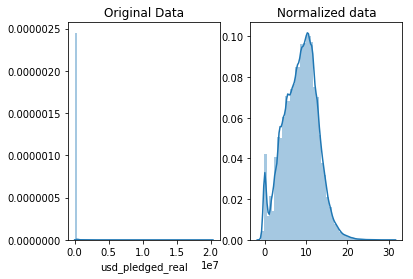

In [148]:
# Get the index of all positive pledges (Box-Cox only takes postive values)
index_of_positive_pledges = kickstarters_2017.usd_pledged_real > 0

# get only positive pledges (using their indexes)
positive_pledges = kickstarters_2017.usd_pledged_real.loc[index_of_positive_pledges]

# normalize the pledges (w/ Box-Cox)
normalized_pledges = stats.boxcox(positive_pledges)[0]

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(positive_pledges, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized_pledges, ax=ax[1])
ax[1].set_title("Normalized data")

<b><span style="color:red">Try the same code on the pleadged attribute. What's your observation?</span></b>

## Part 2 - Detecting and Handling Outliers



Python has a basic module, <a href="https://github.com/vc1492a/PyNomaly">PyNomaly</a>, that provides basic outlier detection functionality with limited algorithmic implementations. A more sophisticated module we will use for outlier detection is PyOD. <a href="https://github.com/yzhao062/pyod">PyOD</a> is a scalable Python toolkit for detecting outliers in multivariate data. It provides access to around 20 outlier detection algorithms under a single <a href="https://pyod.readthedocs.io/en/latest/">well-documented API</a>.

You will need to install PyOD before you can proceed with this part of the notebook. To install PyOD, run these commands on the command prompt:

    pip install pyod
    pip install --upgrade pyod  # to make sure that the latest version is installed!


### The BigMart Sales Dataset

The data scientists at BigMart collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. BigMart wanted to have a predictive model that can predict the amount of sales for each store, and thus attempt to understand the properties of products and stores which play a key role in increasing sales. The data may have missing values as some stores might not report all the data due to technical glitches. 

The data is divided into a training set (8523 records) and a test set (5681 records). The training dataset has both variables plus the amount of sales. The variables/attributes in the dataset are described as follows:

<b>Item_Identifier</b>: Unique product ID
<br><b>Item_Weight</b>: Weight of product
<br><b>Item_Fat_Content</b>: Whether the product is low fat or not
<br><b>Item_Visibility</b>: The % of total display area of all products in a store allocated to the particular product
<br><b>Item_Type</b>: The category to which the product belongs
<br><b>Item_MRP</b>: Maximum Retail Price (list price) of the product
<br><b>Outlet_Identifier</b>: Unique store ID
<br><b>Outlet_Establishment_Year</b>: The year in which store was established
<br><b>Outlet_Size</b>: The size of the store in terms of ground area covered
<br><b>Outlet_Location_Type</b>: The type of city in which the store is located
<br><b>Outlet_Type</b>: Whether the outlet is just a grocery store or some sort of supermarket
<br><b>Item_Outlet_Sales</b>: Sales of the product in the particulat store. This is the outcome variable to be predicted.

<b><span style="color:blue">Important Note: </b>Item_Fat_Content has catagories: Low_Fat, reg, regular, LF, low_fat.</span>


Download the <a href="https://www.kaggle.com/brijbhushannanda1979/bigmart-sales-data#Train.csv">BigMart Sales dataset</a> and save it to your local machine.

Import the modules we will need and then import the data. Each of the outlier detection modules assigns an <b>outlier score</b>, which means a module scores each data point rather than uses threshold value to determine whether the point is an outlier or not.

In [46]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import font_manager

# Import models
from pyod.models.hbos import HBOS # histogram-based outlier detection module
from pyod.models.cblof import CBLOF # cluster-based local outlier factor detection module
from pyod.models.knn import KNN # k nearest neighbors module
from pyod.models.lof import LOF # local outlier factor module

# More outlier detection methods can be used, such as 
#from pyod.models.feature_bagging import FeatureBagging 
#from pyod.models.abod import ABOD
#from pyod.models.iforest import IForest

# Reading the big mart sales training data
bigmart = pd.read_csv("data/bigmart_train.csv")

Let’s plot Item MRP vs Item Outlet Sales to understand the data:

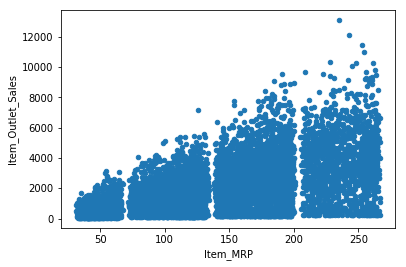

In [47]:
# Use the simple scatter method associated with pandas 
bigmart.plot.scatter('Item_MRP','Item_Outlet_Sales')

The range of Item Outlet Sales is from 0 to 12000 and Item MRP is from 0 to 250. We will scale down both these features to a range between 0 and 1 (min-max scaling). This is required to create a explainable visualization (it will become way too stretched otherwise).

In [150]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
bigmart[['Item_MRP','Item_Outlet_Sales']] = scaler.fit_transform(bigmart[['Item_MRP','Item_Outlet_Sales']])
bigmart[['Item_MRP','Item_Outlet_Sales']].head()

Item_MRP  Item_Outlet_Sales
0  0.927507           0.283587
1  0.072068           0.031419
2  0.468288           0.158115
3  0.640093           0.053555
4  0.095805           0.073651

Store these values in the NumPy array for using in our models later:

In [54]:
X1 = bigmart['Item_MRP'].values.reshape(-1,1) 
X2 = bigmart['Item_Outlet_Sales'].values.reshape(-1,1)
# values method takes a column from pandas dataframe and makes it into an array of values --
# reshape arranges the extracted values in a numpy array with a shape we define --
# an array shape is the number of rows and columns in the array
# when we use parameter -1, it means we don't know the shape of the resulting array (e.g. X1)  -- 
# and numpy will figure it out based on length of array and whatever dimensions left
# in the case of reshape(-1, 1) we tell numpy to figure out the number of rows (parameter -1) but we have one column (parameter 1)

X = np.concatenate((X1,X2),axis=1) # define a NumPy array from the two arrays

We will create a dictionary data structure to store the model names and function calls, and will add models to it and see how each model predicts outliers. This way it's easier to write the model application code once and run it in a loop.

You can set the value of the outlier fraction according to your problem and your understanding of the data. In our example, the goal is to detect 5% observations that are not similar to the rest of the data. The value of outlier fraction as therefore defined as 0.05.

In [61]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define four outlier detection tools to be compared
# KNN uses the data point's distance to the farthest KNN for the outlier score
# Average KNN uses the average score for the data point's k nearest neighbors as the outlier score

# Create dictionary structure with model names and function calls
classifiers = {
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),    
    'Local Outlier Factor (LOF)':LOF(contamination=outliers_fraction),
    #'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    #'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

Now, we will fit the data to each outlier detection model one by one and see how differently each model predicts the outliers.

OUTLIERS :  501 INLIERS :  8022 Histogram-base Outlier Detection (HBOS)


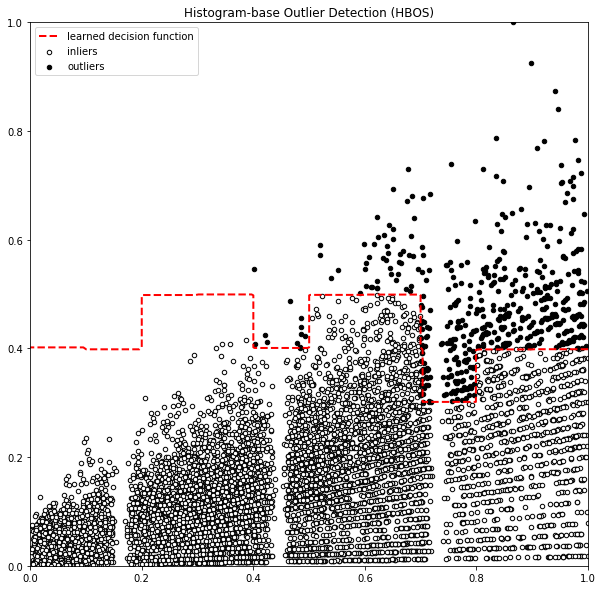

OUTLIERS :  344 INLIERS :  8179 Local Outlier Factor (LOF)


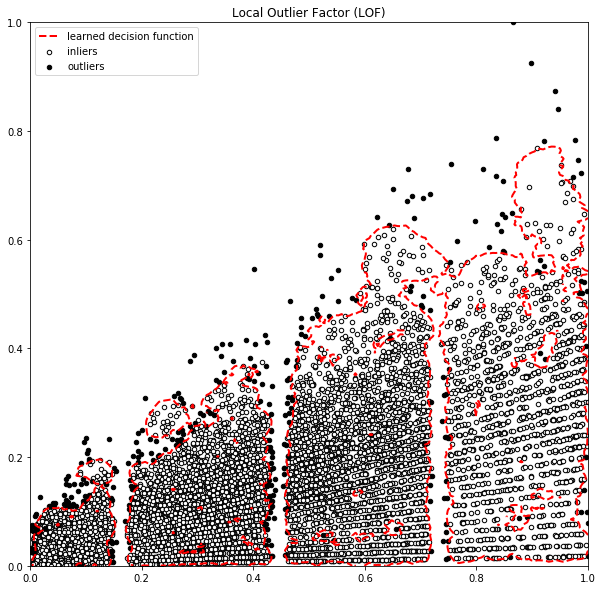

OUTLIERS :  311 INLIERS :  8212 K Nearest Neighbors (KNN)


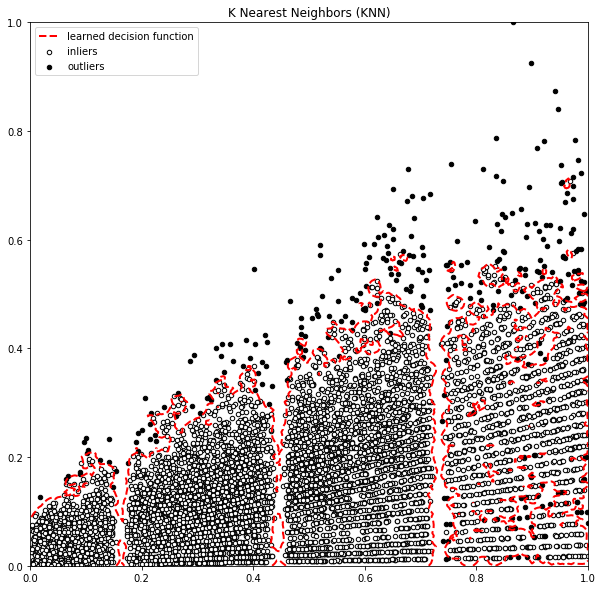

In [63]:
# Define a grid with equally spaced cells using NumPy for visualization
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

# for iterator, call each model name and model function from the dictionary
for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # Fit the model in current iteration to data X which contains the two scaled attributes
    clf.fit(X) 
    
    # Predict raw anomaly score for entire dataset X using decision function
    # Decision function is a conceptual separator between two classes in the dataset, in this case "normal" versus "outlier"
    scores_pred = clf.decision_function(X) * -1 
        
    # Label each data point in X as outlier or inlier: label = 1 is for outlier and label = 0 is for inlier
    y_pred = clf.predict(X)
    
    # Count normal data points as all data points minus the data points for which the prediction is 1 (outlier)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    
    # Count outliers as those data points with label 1
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # At this point, you can simply print the outliers [y_pred=1], but if the dataset is large, it is easier to visualize
    
    # Let's visualize
    plt.figure(figsize=(10, 10))
    
    # Define a copy of dataframe and add to it another attribute/variable and name it "outlier"
    bigmartx = bigmart
    # then append the labels array y_pred to the copy
    bigmartx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    # This is to plot the scatter plot again but with outlier flags this time
    IX1 =  np.array(bigmartx['Item_MRP'][bigmartx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(bigmartx['Item_Outlet_Sales'][bigmartx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    # This is to plot the scatter plot again but with outlier flags this time
    # Defining a NumPy array is the same as taking the values of a dataframe column
    OX1 =  bigmartx['Item_MRP'][bigmartx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  bigmartx['Item_Outlet_Sales'][bigmartx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # Threshold value over entire dataset to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # Decision function calculates the raw anomaly score for every point in grid for visualization
    # c_ method (in next code lines) stacks 1-D arrays as columns in one 2-D array, so xx will be first column and yy will be second column
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1 
    Z = Z.reshape(xx.shape) # make Z array have the same shape as xx array; 1-D array
          
    # Fill blue map colormap from minimum anomaly score to threshold value
    #plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # Draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # Fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    #plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'], loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

<span style = "color:red"><b>Now try to write code that will remove the outliers from the dataset.</b></spn>
<br><span style = "color:red"><b>You can start by one column to make it simple. You can dig up code from the Web that will do the trick and apply it to the dataset here.</b></spn>

## Part 3: Encoding, Discretization, and Aggregation

Encoding categorical attributes involves either replacing the categories/levels in a categorical attributes with numeric values/codes (label encoding), or expanding a categorical attribute to multiple attributes whose number is equal to the number of categories in the attribute (one-hot encoding). One-hot encoding is more frequently used, where each object will have the values of the expanded attributes encoded with 1 or 0 according to the presence of a category value for that object. One-hot encoding is a way of transforming a categorical attribute into numerical values that are either 0 or 1, while label encoding involves the use of multiple numerical values corresponding to the number of categories.

Discretization, on the other hand, involves taking a numerical attribute and dividing its range of continuous values into intervals, and then assigning nominal labels to these intervals. This helps control the number of values that can be present in an attribute.

Aggregation is a way of reducing the size of the dataset and investigating interesting summaries according to different granularities in the dataset.

Let's see how these processes can be applied to a famous dataset; the US census dataset.

### The Adult Income Dataset

The <a href="https://www.kaggle.com/wenruliu/adult-income-dataset">Adult Income Dataset</a> includes data about an individual’s annual income. Intuitively, income is influenced by the individual’s education level, age, gender, occupation, and etc. The dataset contains 14 columns detailing attributes related to the demographics and other features that describe a person. The target attribute, Income, is divide into two classes: <=50K and >50K. A description of the attributes follows:

<b>age</b>: continuous.
<br><b>workclass</b>: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
<br><b>fnlwgt</b>: continuous.
<br><b>education</b>: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
<br><b>education-num</b>: continuous.
<br><b>marital-status</b>: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
<br><b>occupation</b>: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
<br><b>relationship</b>: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
<br><b>race</b>: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
<br><b>gender</b>: Female, Male.
<br><b>capital-gain</b>: continuous.
<br><b>capital-loss</b>: continuous.
<br><b>hours-per-week</b>: continuous.
<br><b>native-country</b>: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
<br><b>income</b>: >50K, <=50K

Let's import some important modules and then import the data.

In [67]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

income_df = pd.read_csv("data/income_data.csv")

# List attribute names
print (list(income_df))

# Display the shape of the dataset (#rows, #columns)
print (income_df.shape)

['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
(48842, 15)


You may want to inspect some records from the dataset to get a feel of the values.

In [70]:
#income_df.head() # first 5 rows
income_df.sample(10) # random 10 rows

age         workclass  fnlwgt     education  educational-num  \
30326   51         Local-gov  170579       HS-grad                9   
3693    36           Private   82488     Bachelors               13   
32277   58  Self-emp-not-inc  141165       HS-grad                9   
15558   29           Private  163167     Bachelors               13   
42165   52       Federal-gov  192065  Some-college               10   
25635   49           Private  180532       Masters               14   
33612   39           Private  184801     Bachelors               13   
48679   24           Private  222005       HS-grad                9   
8170    56  Self-emp-not-inc  140729       HS-grad                9   
15761   29           Private  101108       HS-grad                9   

              marital-status         occupation    relationship  \
30326     Married-civ-spouse   Transport-moving         Husband   
3693      Married-civ-spouse       Adm-clerical            Wife   
32277     Married-civ-spouse    Farming-fishing         Husband   
15558     Married-civ-spouse              Sales         Husband   
42165              Separated    Exec-managerial   Not-in-family   
25635  Married-spouse-absent     Prof-specialty   Not-in-family   
33612     Married-civ-spouse     Prof-specialty         Husband   
48679          Never-married      Other-service  Other-relative   
8170      Married-civ-spouse  Machine-op-inspct         Husband   
15761               Divorced      Other-service   Not-in-family   

                     race  gender  capital-gain  capital-loss  hours-per-week  \
30326               White    Male             0             0              40   
3693   Asian-Pac-Islander  Female             0             0              40   
32277               White    Male             0             0              50   
15558               White    Male             0             0              55   
42165               White  Female             0             0              40   
25635               White    Male             0             0              40   
33612               White    Male             0             0              40   
48679               White    Male             0             0              30   
8170                White    Male             0             0              45   
15761               White  Female             0             0              15   

      native-country income  
30326  United-States   >50K  
3693     Philippines  <=50K  
32277  United-States  <=50K  
15558  United-States   >50K  
42165  United-States  <=50K  
25635  United-States  <=50K  
33612  United-States   >50K  
48679  United-States  <=50K  
8170   United-States  <=50K  
15761  United-States  <=50K

A description of each attribute helps us understand the distribution of its values.

In [71]:
income_df.describe()

age        fnlwgt  educational-num  capital-gain  \
count  48842.000000  4.884200e+04     48842.000000  48842.000000   
mean      38.643585  1.896641e+05        10.078089   1079.067626   
std       13.710510  1.056040e+05         2.570973   7452.019058   
min       17.000000  1.228500e+04         1.000000      0.000000   
25%       28.000000  1.175505e+05         9.000000      0.000000   
50%       37.000000  1.781445e+05        10.000000      0.000000   
75%       48.000000  2.376420e+05        12.000000      0.000000   
max       90.000000  1.490400e+06        16.000000  99999.000000   

       capital-loss  hours-per-week  
count  48842.000000    48842.000000  
mean      87.502314       40.422382  
std      403.004552       12.391444  
min        0.000000        1.000000  
25%        0.000000       40.000000  
50%        0.000000       40.000000  
75%        0.000000       45.000000  
max     4356.000000       99.000000

<span style = "color:red"><b>What do you notice in the results of the</b> `describe()` <b>method call?</b></span>

Let's investigate descriptions of individual attributes.

In [73]:
def summerize_data(df):
    for column in df.columns:
        print (column)
        if df.dtypes[column] == np.object: # Categorical data
            print (df[column].value_counts())
        else:
            print (df[column].describe()) 
            
        print ('\n')
    
summerize_data(income_df)

age
count    48842.000000
mean        38.643585
std         13.710510
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64


workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64


fnlwgt
count    4.884200e+04
mean     1.896641e+05
std      1.056040e+05
min      1.228500e+04
25%      1.175505e+05
50%      1.781445e+05
75%      2.376420e+05
max      1.490400e+06
Name: fnlwgt, dtype: float64


education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6t

#### Label Encoding

We can encode categorical attributes as numbers without expanding. This involves assigning a numeric code for each category in a categorical attribute, or <b>Label Encoding</b>.

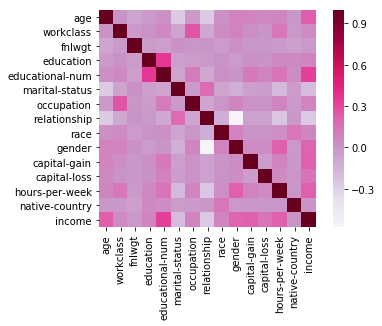

age  workclass  fnlwgt  education  educational-num  marital-status  \
48837   27          4  257302          7               12               2   
48838   40          4  154374         11                9               2   
48839   58          4  151910         11                9               6   
48840   22          4  201490         11                9               4   
48841   52          5  287927         11                9               2   

       occupation  relationship  race  gender  capital-gain  capital-loss  \
48837          13             5     4       0             0             0   
48838           7             0     4       1             0             0   
48839           1             4     4       0             0             0   
48840           1             3     4       1             0             0   
48841           4             5     4       0         15024             0   

       hours-per-week  native-country  income  
48837              38              39       0  
48838              40              39       1  
48839              40              39       0  
48840              20              39       0  
48841              40              39       1

In [84]:
# Function to encode categorical attributes in a given dataset as numbers
def number_encode_features(df):
    result = df.copy() # take a copy of the dataframe
    for column in result.columns:
        if result.dtypes[column] == np.object: # if attribute is categorical
            # Apply LabelEncoder method to attribute
            # fit will infer the number of numerical values needed by counting the number of categories
            # then transform will replace each category with its numerical counterpart
            result[column] = preprocessing.LabelEncoder().fit_transform(result[column])
    return result

# Apply function defined above to income dataset
encoded_data = number_encode_features(income_df)
# Now that the attributes are numerical, it is possible to calculate correlation and plot it
sns.heatmap(encoded_data.corr(), square=True, cmap='PuRd')
plt.show()

# Display last 5 records in transformed dataset to verify numerical transformation
encoded_data.tail(5)

<span style="color:red"><b>Can you tell if there are redundant attributes from the correlation matrix shown above?</b></span>

If there is an attribute that you are sure is rdundant and adds no new information to future analysis, you can delete it using

    del dataframe["attribute-name"]

<span style="color:red"><b>Do you think that attributes in the dataset need scaling?</b></span>

If so, do apply scaling using any of the methods illustrated in Part 1.

<span style="color:red"><b>What about missing values?</b></span>

You may want to make a decision on how to handle missing values before you proceed, or apply encoding and see if it gets affected by missing values.

#### One-hot Encoding

Now let's try one-hot encoding.

The reason one-hot encoding may be needed and useful is when specific values in a categorical attribute may be correlated with specific objects with certain traits. For example, if you investigate the correlation between the <b>gender</b> and <b>relationship</b> attributes, you may find that "female" and "wife" are correlated, and "male" and "husband", but not gender and relationshiop as a whole.

In [96]:
# Try one hot encoding

# Copy the original data
encoded_income_df = income_df.copy()

# Select the numeric columns
numeric_subset = income_df.select_dtypes('number')
# Select the categorical columns
categorical_subset = income_df.select_dtypes('object')

# One hot encode
# pandas has a handy method to apply one-hot encoding --
# takes a categorical attributes and defines indicator "dummy" attributes
# We will note one-hot encode the income attribute, since it is the response attribute that is the target of analysis
new_categorical_subset = pd.get_dummies(categorical_subset[categorical_subset.columns.drop("income")])

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
encoded_income_df = pd.concat([numeric_subset, new_categorical_subset], axis = 1)
print (encoded_income_df.head())

   age  fnlwgt  educational-num  capital-gain  capital-loss  hours-per-week  \
0   25  226802                7             0             0              40   
1   38   89814                9             0             0              50   
2   28  336951               12             0             0              40   
3   44  160323               10          7688             0              40   
4   18  103497               10             0             0              30   

   workclass_?  workclass_Federal-gov  workclass_Local-gov  \
0            0                      0                    0   
1            0                      0                    0   
2            0                      0                    1   
3            0                      0                    0   
4            1                      0                    0   

   workclass_Never-worked  ...  native-country_Portugal  \
0                       0  ...                        0   
1                       0  ...    

<span style="color:red"><b>What do you notice with the workclass attribute?</b></span>

We can use the sklearn to do the one-hot encoding, much the same way we did label encoding.

In [135]:
# Apply one-hot encoding function defined above to categorical attributes in income dataset, except income attribute
onehot_categorical_subset = preprocessing.OneHotEncoder().fit_transform(categorical_subset[categorical_subset.columns.drop("income")])

# OneHotEncoder() returns a matrix object, and we need that to be converted to a dataframe to construct new encoded dataset
# So, convert result to array object, then make the result as list and convert to dataframe object
# The reason we use the list method is to keep the sparseness of the resulting one-hot-encoded attributes
# Experiment with removing the list function call to see how the resulting attributes will be different
new_onehot_categorical_subset = pd.DataFrame(list(onehot_categorical_subset.toarray()))

# Join the dataframes using concat
# Make sure to use axis = 1 to perform a column bind
# Remember, we applied one hot encoding on categorical attributes except income, so we need it back
onehot_encoded_data = pd.concat([numeric_subset, new_onehot_categorical_subset, income_df["income"]], axis = 1)

# Display last 5 records in transformed dataset to verify numerical transformation

onehot_encoded_data.tail()

age  fnlwgt  educational-num  capital-gain  capital-loss  \
48837   27  257302               12             0             0   
48838   40  154374                9             0             0   
48839   58  151910                9             0             0   
48840   22  201490                9             0             0   
48841   52  287927                9         15024             0   

       hours-per-week    0    1    2    3  ...   93   94   95   96   97   98  \
48837              38  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
48838              40  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
48839              40  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
48840              20  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
48841              40  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   

        99  100  101  income  
48837  1.0  0.0  0.0   <=50K  
48838  1.0  0.0  0.0    >50K  
48839  1.0  0.0  0.0   <=50K  
48840  1.0  0.0  0.0   <=50K  
48841  1.0  0.0  0.0    >50K  

[5 rows x 109 columns]

You can notice that the `OneHotEncoder()` method does not keep meaningful column names. It works fine if you have one categorical column or multiple columns representing the same semantic meaning (e.g. words in a document). 

A better package we can use that will keep meaningful column names is the `OneHotCategoricalEncoder()`, but you need to install the feature-engine package using:

    pip install feature-engine

at the command prompt. Let's try this method.

In [137]:
# Import feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder

# Define encoder method
encoder = OneHotCategoricalEncoder()

# Apply encoder to categorical subset, except income
onehot_categorical_subset2 = encoder.fit_transform(categorical_subset[categorical_subset.columns.drop("income")])

# Beauty of feature-engine encoder method is it already returns a dataframe, so we need not worry about conversions
# Concatenate and reconstruct new dataset
onehot_encoded_data2 = pd.concat([numeric_subset, onehot_categorical_subset2, income_df["income"]], axis = 1)

# display last 5 records
onehot_encoded_data2.tail()

age  fnlwgt  educational-num  capital-gain  capital-loss  \
48837   27  257302               12             0             0   
48838   40  154374                9             0             0   
48839   58  151910                9             0             0   
48840   22  201490                9             0             0   
48841   52  287927                9         15024             0   

       hours-per-week  workclass_Private  workclass_Local-gov  workclass_?  \
48837              38                  1                    0            0   
48838              40                  1                    0            0   
48839              40                  1                    0            0   
48840              20                  1                    0            0   
48841              40                  0                    0            0   

       workclass_Self-emp-not-inc  ...  native-country_Ecuador  \
48837                           0  ...                       0   
48838                           0  ...                       0   
48839                           0  ...                       0   
48840                           0  ...                       0   
48841                           0  ...                       0   

       native-country_Yugoslavia  native-country_Hungary  native-country_Hong  \
48837                          0                       0                    0   
48838                          0                       0                    0   
48839                          0                       0                    0   
48840                          0                       0                    0   
48841                          0                       0                    0   

       native-country_Greece  native-country_Trinadad&Tobago  \
48837                      0                               0   
48838                      0                               0   
48839                      0                               0   
48840                      0                               0   
48841                      0                               0   

       native-country_Outlying-US(Guam-USVI-etc)  native-country_France  \
48837                                          0                      0   
48838                                          0                      0   
48839                                          0                      0   
48840                                          0                      0   
48841                                          0                      0   

       native-country_Holand-Netherlands  income  
48837                                  0   <=50K  
48838                                  0    >50K  
48839                                  0   <=50K  
48840                                  0   <=50K  
48841                                  0    >50K  

[5 rows x 109 columns]

#### Discretization 

Now let's discretize some of the numerical attributes. We will work with the <b>age</b> and the <b>hours-per-week</b> as examples.

In [138]:
# Group the "age" column
age_group = [] # define array structure
for age in encoded_income_df["age"]:
    if age < 25:
        age_group.append("<25")
    elif 25 <= age <= 34:
        age_group.append("25-34")
    elif 34 < age <= 44:
        age_group.append("35-44")
    elif 44 < age <= 54:
        age_group.append("45-54")
    elif 54 < age <= 65:
        age_group.append("55-64")
    else:
        age_group.append("65 and over")
        
# Copy dataframe to keep original 
new_income_df = encoded_income_df.copy()
new_income_df["age_group"] = age_group
del new_income_df["age"]

# Same thing for "hours-per-week"
work_hours_per_week = []
for hours in encoded_income_df["hours-per-week"]:
    if hours < 16:
        work_hours_per_week.append("<16")
    elif 16 <= hours <= 32:
        work_hours_per_week.append("16-32")
    elif 32 < hours <= 48:
        work_hours_per_week.append("32-48")
    elif 48 < hours <= 60:
        work_hours_per_week.append("48-60")
    else:
        work_hours_per_week.append("60 and over")
        
new_income_df["work_hours_per_week"] = work_hours_per_week
del new_income_df["hours-per-week"]

new_income_df.head(10)

fnlwgt  educational-num  capital-gain  capital-loss  workclass_?  \
0  226802                7             0             0            0   
1   89814                9             0             0            0   
2  336951               12             0             0            0   
3  160323               10          7688             0            0   
4  103497               10             0             0            1   
5  198693                6             0             0            0   
6  227026                9             0             0            1   
7  104626               15          3103             0            0   
8  369667               10             0             0            0   
9  104996                4             0             0            0   

   workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                      0                    0                       0   
1                      0                    0                       0   
2                      0                    1                       0   
3                      0                    0                       0   
4                      0                    0                       0   
5                      0                    0                       0   
6                      0                    0                       0   
7                      0                    0                       0   
8                      0                    0                       0   
9                      0                    0                       0   

   workclass_Private  workclass_Self-emp-inc  ...  native-country_Scotland  \
0                  1                       0  ...                        0   
1                  1                       0  ...                        0   
2                  0                       0  ...                        0   
3                  1                       0  ...                        0   
4                  0                       0  ...                        0   
5                  1                       0  ...                        0   
6                  0                       0  ...                        0   
7                  0                       0  ...                        0   
8                  1                       0  ...                        0   
9                  1                       0  ...                        0   

   native-country_South  native-country_Taiwan  native-country_Thailand  \
0                     0                      0                        0   
1                     0                      0                        0   
2                     0                      0                        0   
3                     0                      0                        0   
4                     0                      0                        0   
5                     0                      0                        0   
6                     0                      0                        0   
7                     0                      0                        0   
8                     0                      0                        0   
9                     0                      0                        0   

   native-country_Trinadad&Tobago  native-country_United-States  \
0                               0                             1   
1                               0                             1   
2                               0                             1   
3                               0                             1   
4                               0                             1   
5                               0                             1   
6                               0                             1   
7                               0                             1   
8                               0                             1   
9                               0                             

There is an easier way in python than using if else statements. Pandas `cut` function can be used to group continuous or countable data in to bins.

In [143]:
# Take another copy of the original dataset
new_income_df2 = encoded_income_df.copy()

# Cut the age attribute into intervals
age_group2 = pd.cut(new_income_df2.age, [20,40,60,80])

# You can label the intervals for more meaningful representation
#age_group2 = pd.cut(new_income_df2.age, [20,40,60,80],labels=['young','middle-aged','old'])

new_income_df2["age_group"] = age_group2
del new_income_df2["age"]

new_income_df2.head(10)

fnlwgt  educational-num  capital-gain  capital-loss  hours-per-week  \
0  226802                7             0             0              40   
1   89814                9             0             0              50   
2  336951               12             0             0              40   
3  160323               10          7688             0              40   
4  103497               10             0             0              30   
5  198693                6             0             0              30   
6  227026                9             0             0              40   
7  104626               15          3103             0              32   
8  369667               10             0             0              40   
9  104996                4             0             0              10   

   workclass_?  workclass_Federal-gov  workclass_Local-gov  \
0            0                      0                    0   
1            0                      0                    0   
2            0                      0                    1   
3            0                      0                    0   
4            1                      0                    0   
5            0                      0                    0   
6            1                      0                    0   
7            0                      0                    0   
8            0                      0                    0   
9            0                      0                    0   

   workclass_Never-worked  workclass_Private  ...  native-country_Puerto-Rico  \
0                       0                  1  ...                           0   
1                       0                  1  ...                           0   
2                       0                  0  ...                           0   
3                       0                  1  ...                           0   
4                       0                  0  ...                           0   
5                       0                  1  ...                           0   
6                       0                  0  ...                           0   
7                       0                  0  ...                           0   
8                       0                  1  ...                           0   
9                       0                  1  ...                           0   

   native-country_Scotland  native-country_South  native-country_Taiwan  \
0                        0                     0                      0   
1                        0                     0                      0   
2                        0                     0                      0   
3                        0                     0                      0   
4                        0                     0                      0   
5                        0                     0                      0   
6                        0                     0                      0   
7                        0                     0                      0   
8                        0                     0                      0   
9                        0                     0                      0   

   native-country_Thailand  native-country_Trinadad&Tobago  \
0                        0                               0   
1                        0                               0   
2                        0                               0   
3                        0                               0   
4                        0                               0   
5                        0                               0   
6                        0                               0   
7                        0                               0   
8                        0                               0   
9                        0                               0   

   native-country_United-States  native-country_Vietnam  \
0                             1              

<span style="color:red"><b>It is possible to use</b></span> `cut` <span style="color:red"><b>with quantiles instead of intervals (depth-based binning, # of ovservations in bin instead of interval of values). Read relevant documentation of the function on the Web and apply quantile cutting to the age attribute and construct new dataset.</b></span>

<span style="color:red"><b>Apply one-hot encoding again to the discretized attributes!</b></span>

#### Aggregation

Now let's try to aggregate numerical values according to a categorical attribute. If there was a time attribute then aggregation could have been performed on different time intervals. For the dataset we have it is sufficient to apply aggregation over the workclass attribute for now. We will use the `groupby` function. Then, it is possible to compute aggregate values (e.g. mean) per workclass group for the numerical attributes.

In [146]:
# We will work with the original dataset income_df
# Group workclass attribute by its categorical values
grouped_income = income_df.groupby(["workclass"])

# Compute mean per group using agg function
grouped_income.agg(np.mean).head()

age         fnlwgt  educational-num  capital-gain  \
workclass                                                               
?             40.141122  187254.773491         9.251161    502.946052   
Federal-gov   42.577514  183590.028631        10.937151    923.287709   
Local-gov     41.676020  190161.134885        11.032207    798.228635   
Never-worked  19.900000  215033.300000         7.500000      0.000000   
Private       36.903144  192669.212499         9.875715    896.135374   

              capital-loss  hours-per-week  
workclass                                   
?                67.634870       31.812433  
Federal-gov     108.884078       41.513268  
Local-gov       102.124043       40.847258  
Never-worked      0.000000       28.900000  
Private          80.768478       40.273137

The `agg` function intelligently ignores categorical attributes.

<span style="color:red"><b>Why did we not apply the aggregation function on the encoded dataset?</b></span>